In [218]:
using ITensors
using PyCall
using Plots
using Random, Distributions
using DelimitedFiles

# Creating Number States in ITensor

In [29]:
sites = siteinds("Qudit", 10; dim=10);

In [30]:
mps = randomMPS(sites; linkdims=4)

MPS
[1] ((dim=10|id=507|"Qudit,Site,n=1"), (dim=4|id=821|"Link,l=1"))
[2] ((dim=4|id=821|"Link,l=1"), (dim=10|id=627|"Qudit,Site,n=2"), (dim=4|id=808|"Link,l=2"))
[3] ((dim=4|id=808|"Link,l=2"), (dim=10|id=996|"Qudit,Site,n=3"), (dim=4|id=474|"Link,l=3"))
[4] ((dim=4|id=474|"Link,l=3"), (dim=10|id=101|"Qudit,Site,n=4"), (dim=4|id=800|"Link,l=4"))
[5] ((dim=4|id=800|"Link,l=4"), (dim=10|id=203|"Qudit,Site,n=5"), (dim=4|id=851|"Link,l=5"))
[6] ((dim=4|id=851|"Link,l=5"), (dim=10|id=63|"Qudit,Site,n=6"), (dim=4|id=80|"Link,l=6"))
[7] ((dim=4|id=80|"Link,l=6"), (dim=10|id=530|"Qudit,Site,n=7"), (dim=4|id=365|"Link,l=7"))
[8] ((dim=4|id=365|"Link,l=7"), (dim=10|id=120|"Qudit,Site,n=8"), (dim=4|id=999|"Link,l=8"))
[9] ((dim=4|id=999|"Link,l=8"), (dim=10|id=972|"Qudit,Site,n=9"), (dim=4|id=218|"Link,l=9"))
[10] ((dim=4|id=218|"Link,l=9"), (dim=10|id=187|"Qudit,Site,n=10"))


In [31]:
mps2 = randomMPS(sites; linkdims=4)

MPS
[1] ((dim=10|id=507|"Qudit,Site,n=1"), (dim=4|id=141|"Link,l=1"))
[2] ((dim=4|id=141|"Link,l=1"), (dim=10|id=627|"Qudit,Site,n=2"), (dim=4|id=894|"Link,l=2"))
[3] ((dim=4|id=894|"Link,l=2"), (dim=10|id=996|"Qudit,Site,n=3"), (dim=4|id=333|"Link,l=3"))
[4] ((dim=4|id=333|"Link,l=3"), (dim=10|id=101|"Qudit,Site,n=4"), (dim=4|id=946|"Link,l=4"))
[5] ((dim=4|id=946|"Link,l=4"), (dim=10|id=203|"Qudit,Site,n=5"), (dim=4|id=394|"Link,l=5"))
[6] ((dim=4|id=394|"Link,l=5"), (dim=10|id=63|"Qudit,Site,n=6"), (dim=4|id=799|"Link,l=6"))
[7] ((dim=4|id=799|"Link,l=6"), (dim=10|id=530|"Qudit,Site,n=7"), (dim=4|id=937|"Link,l=7"))
[8] ((dim=4|id=937|"Link,l=7"), (dim=10|id=120|"Qudit,Site,n=8"), (dim=4|id=102|"Link,l=8"))
[9] ((dim=4|id=102|"Link,l=8"), (dim=10|id=972|"Qudit,Site,n=9"), (dim=4|id=990|"Link,l=9"))
[10] ((dim=4|id=990|"Link,l=9"), (dim=10|id=187|"Qudit,Site,n=10"))


# Try PyCall with SaX

In [13]:
pyts = pyimport("pyts.approximation")
X = randn(3, 100);

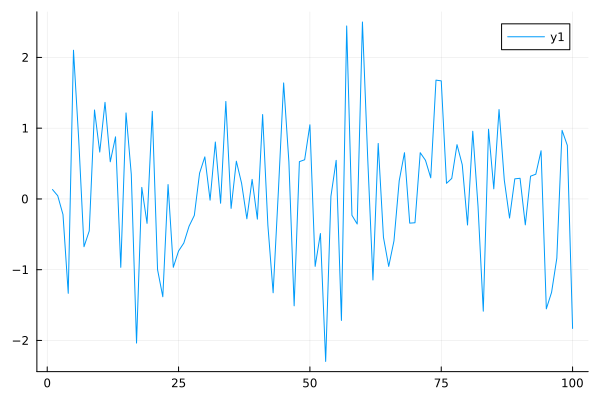

In [14]:
plot(X[1, :])

In [207]:
n_bins = 5
sax = pyts.SymbolicAggregateApproximation(n_bins=n_bins, strategy="normal")
X_sax = sax.fit_transform(X);
X_sax[1][80]

"b"

In [208]:
sites = siteinds("Qudit", 100; dim=n_bins);

Map this test series into a product state

In [209]:
X_sax[1][1]

"c"

In [210]:
mapping = Dict(
    "a" => 1,
    "b" => 2, 
    "c" => 3,
    "d" => 4,
    "e" => 5
)

Dict{String, Int64} with 5 entries:
  "c" => 3
  "e" => 5
  "b" => 2
  "a" => 1
  "d" => 4

In [211]:
letter = "a"
mapping[letter]

1

In [212]:
function SaxToEncoding(sax_sample, sites)
    mapping = Dict(
        "a" => 1,
        "b" => 2, 
        "c" => 3,
        "d" => 4,
        "e" => 5
    )
    product_state = MPS(sites; linkdims=1)
    for j=1:length(sites)
        T = ITensor(sites[j])
        letter = sax_sample[j]
        T[mapping[letter]] = 1
        product_state[j] = T
    end
    return product_state
end

SaxToEncoding (generic function with 1 method)

In [213]:
ps_1 = SaxToEncoding(X_sax[1], sites)
ps_2 = SaxToEncoding(X_sax[2], sites)
ps_3 = SaxToEncoding(X_sax[3], sites)

MPS
[1] ((dim=5|id=740|"Qudit,Site,n=1"),)
[2] ((dim=5|id=300|"Qudit,Site,n=2"),)
[3] ((dim=5|id=741|"Qudit,Site,n=3"),)
[4] ((dim=5|id=143|"Qudit,Site,n=4"),)
[5] ((dim=5|id=663|"Qudit,Site,n=5"),)
[6] ((dim=5|id=531|"Qudit,Site,n=6"),)
[7] ((dim=5|id=16|"Qudit,Site,n=7"),)
[8] ((dim=5|id=418|"Qudit,Site,n=8"),)
[9] ((dim=5|id=921|"Qudit,Site,n=9"),)
[10] ((dim=5|id=293|"Qudit,Site,n=10"),)
[11] ((dim=5|id=88|"Qudit,Site,n=11"),)
[12] ((dim=5|id=669|"Qudit,Site,n=12"),)
[13] ((dim=5|id=355|"Qudit,Site,n=13"),)
[14] ((dim=5|id=967|"Qudit,Site,n=14"),)
[15] ((dim=5|id=76|"Qudit,Site,n=15"),)
[16] ((dim=5|id=123|"Qudit,Site,n=16"),)
[17] ((dim=5|id=795|"Qudit,Site,n=17"),)
[18] ((dim=5|id=644|"Qudit,Site,n=18"),)
[19] ((dim=5|id=103|"Qudit,Site,n=19"),)
[20] ((dim=5|id=184|"Qudit,Site,n=20"),)
[21] ((dim=5|id=59|"Qudit,Site,n=21"),)
[22] ((dim=5|id=587|"Qudit,Site,n=22"),)
[23] ((dim=5|id=984|"Qudit,Site,n=23"),)
[24] ((dim=5|id=525|"Qudit,Site,n=24"),)
[25] ((dim=5|id=271|"Qudit,Site,n=

In [215]:
inner(ps_1, ps_2)

0

# Now try with ECG200 Data

In [219]:
ecg_dat = readdlm("../ECG200_TRAIN.txt")
X_train = ecg_dat[:, 2:end]
y_train = Int.(ecg_dat[:, 1])
remap = Dict(-1 => 0, 1 => 1)
y_train = [remap[label] for label in y_train];
y_train = reshape(y_train, length(y_train), 1);

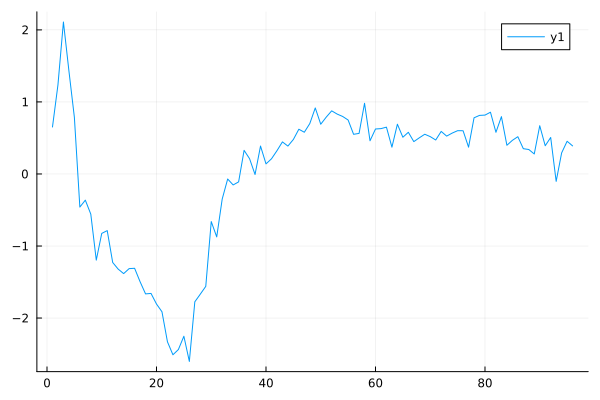

In [227]:
plot(X_train[10
[], :])